# Set-up

In [1]:
import os
import numpy as np
import pandas as pd

import scipy
import scipy.io
import scipy.stats as stats
import pywt

from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
!python --version
print(scipy, scipy.version.version)
print(pywt, pywt.version.version)

Python 3.8.5
<module 'scipy' from 'D:\\WindowsApps\\anaconda\\envs\\ML_for_food\\lib\\site-packages\\scipy\\__init__.py'> 1.6.2
<module 'pywt' from 'D:\\WindowsApps\\anaconda\\envs\\ML_for_food\\lib\\site-packages\\pywt\\__init__.py'> 1.1.1


# Loading the images

In [3]:
def get_data_from_Drive(path_to_data_folder):
  from google.colab import drive
  drive.mount('/content/drive')
  return get_data_from_folder(os.path.join("/content/drive/MyDrive", path_to_data_folder))  

def get_data_from_folder( path_to_data_folder ):
  #Each class must recide in its own folder.
  #Returns data as (image as nparray, class)
  #gathering classes
  class_titles = os.listdir(path_to_data_folder)
  classes_list = list( ( enumerate( class_titles ) ) )
  ordered_image_names = []
  #placing image, class identifier (from classes_list) pairs in a list named data
  data = []
  number_of_images = 0
  errors = 0 
  for gyro_class in classes_list:
    for image_name in os.listdir( os.path.join( path_to_data_folder, gyro_class[1] ) ):
      number_of_images+=1
      try:
        im = Image.open( os.path.join( path_to_data_folder, gyro_class[1] , image_name)  )
        color_image_nparray = np.asarray( im )
        data.append( [color_image_nparray, gyro_class[0]] )
        ordered_image_names.append(image_name)
      except Exception as error :
        errors+=1
        print( error, image_name)

  return data, class_titles, ordered_image_names, ( number_of_images, errors )

# Wavelet Decomposition and Flattening

In [4]:
def get_coefficients_flattend( image, wavelet, levels ):
  #image as nparray with color
  #flattens and groups coefficients by orientation and subband
  #returns as  ( cAn, (cHn, cVn, cDn), … (cH1, cV1, cD1)  )
  #                                 . 
  #                                 .     
  #                                 . 
  #for each picture
  #n is the level of decomposition
  
  pil_image = Image.fromarray(image, "RGB")
  pil_gray_image = pil_image.convert("L")
  gray_img = np.asarray( pil_gray_image ) 
  decomposed = pywt.wavedec2( gray_img , wavelet, level=levels)

  coeff=[]
  for subband in range(levels+1):
    if subband==0:
      coeff.append(np.asarray(decomposed[subband]).flatten())
      continue
    orientations=[]
    for orientation in decomposed[subband]:
      orientations.append( np.asarray(orientation).flatten() )
    coeff.append(orientations)    

  return coeff

def data_to_coeffs(data, wavelet, levels):
  #calculates wavelet coefficients and flattens them for
  #all of the pictures
  #returns 2D-array (coeffs, class)
  toReturn=[]
  for image, class_id in data:
      instance = get_coefficients_flattend(image, wavelet, levels), class_id
      toReturn.append(instance)
  return toReturn

# Goodness of fit check with different distributions through Qqplots

This is done to see which distribution is more suitable for a given image.

In [5]:
def qqplots_of_image(image, wavelet, levels, dist):
  #image as nparray with color
  coeffs=get_coefficients_flattend(image, wavelet, levels)
  alpha=0.2

  fig,axes = plt.subplots(levels+1,3,figsize=(20,20), constrained_layout=True)
  
  #Progress
  print(getattr(dist,"name"), end=": ")
  for m in range(levels+1):
    if m==0:
      sm.qqplot(coeffs[0], dist=dist, fit=True,\
                line="45", linewidth=0.1, alpha=alpha, marker=".", markerfacecolor="black", mew=0, ax=axes[levels-m][0])
      axes[levels-m][0].set_title("Approximation")
      axes[levels-m][0].tick_params(direction="in")
      axes[levels-m][1].remove()
      axes[levels-m][2].remove()
      continue
    for i in range(3):
      if i==0: title="Level "+str(levels-m+1)+": Horizontal"
      if i==1: title="Level "+str(levels-m+1)+": Vertical"
      if i==2: title="Level "+str(levels-m+1)+": Diagonal"

      sm.qqplot(coeffs[m][i], dist=dist, fit=True,\
                line="45", linewidth=0.1, alpha=alpha, marker=".", markerfacecolor="black", mew=0, ax=axes[levels-m][i])
      axes[levels-m][i].set_title(title)
      axes[levels-m][i].tick_params(direction="in")

      #Progress
      print(levels-m+1,i,sep="", end=" ")
  print("")
  
  title="qqplots wavelet={} levels={} dist={}".format(wavelet, levels, getattr(dist,"name"))
  fig.suptitle(title, fontsize=16)
  fig.savefig(title)

  return

# Fitting distributions on the wavelet coefficients  with Matlab

In [6]:
import h5py
import hdf5storage
import numpy as np

def save_coeffs_for_matlab(data, wavelet, levels, save_folder_path):

    all_coeffs = data_to_coeffs(data, wavelet, levels)
    toSave ={"wavelet":wavelet,\
             "levels":levels,\
             "coeffs":np.array(all_coeffs) }

    scipy.io.savemat(os.path.join(save_folder_path ,"coefficients wt="+wavelet+"levels="+str(levels)+".mat"), toSave)
    return


def save_coeffs_for_matlab_hdf5(data, wavelet, levels, save_folder_path):
    #needed when the number of images grows large
    all_coeffs = data_to_coeffs(data, wavelet, levels)
    toSave ={"wavelet":wavelet,\
             "levels":levels,\
             "coeffs":np.array(all_coeffs, dtype=object) }
    
    hdf5storage.write(toSave, '.', "coefficients wt="+wavelet+"levels="+str(levels)+"_hdf5 TEST object.mat", matlab_compatible=True)    
    
    return


def load_distribution_parameters_from_matlab(distribution_parameters_path):
    #after fitting on matlab
    load_dict = scipy.io.loadmat(distribution_parameters_path)

    return load_dict


# Loading distribution parameters from Matlab and preparing them to be used as SVM features in sklearn

In [7]:
def prepare_features_for_scikit(dist_params_select_path):\
  #dist_params_Select is needed to save time by not fitting 
  #distributions to all subbands
  #dist_params_select_path: path to dist_paramsSelect      
    load_dict= load_distribution_parameters_from_matlab(dist_params_select_path)
    
    dist_params = load_dict["dist_params"]
    levels      = load_dict["levels"].reshape(-1)[0]
    wavelet     = load_dict["wavelet"]
    selection   = load_dict["selection"]
#    print(selection)
    features=[]
    labels=[]
    column_names=[]
    for instance_index in range(dist_params.shape[0]):
        features_from_instance=[]

        for level_index in range(dist_params[instance_index,0].shape[1]):
            a=level_index==0
            b=([0, 0] in selection.tolist())

            if a&b:
                for parameter_index in range(dist_params[instance_index,0][0,0][0,:].shape[0]):
                    features_from_instance.append(dist_params[instance_index,0][0,0][0, parameter_index])
                    
                    if instance_index==0:
                        column_name = "".join(str(a) for a in ["Approximation", " Parameter ", parameter_index+1])
                        column_names.append(column_name)
                continue

            for orientation in range(3):
                if [levels-level_index+1, orientation+1] in selection.tolist():
                    for parameter_index in range(dist_params[instance_index,0][0,level_index][0,:].shape[0]):
                        features_from_instance.append(dist_params[instance_index,0][0,level_index][orientation, parameter_index])
                        #creating column name
                        if instance_index==0:
                            column_name="".join(str(a) for a in ["Level ",\
                                                                 levels-level_index+1,\
                                                                 " Orientation ",\
                                                                 orientation+1,\
                                                                 " Parameter ",\
                                                                 parameter_index+1])
                            column_names.append(column_name)

        features.append(features_from_instance)
        labels.append(dist_params[instance_index,1].reshape(-1)[0])
    
    #dataframe set up
    df = pd.DataFrame(features, columns=column_names)
    df["Labels"] = labels
        
    return df

In [8]:
#checking dist_params_select
dist_paramsSelect_folder_path = "E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\"    
dist_paramsSelect_name = "dist_paramsSelect wt=db4 levels=3 dist=Normal.mat"
dist_paramsSelect_path=os.path.join(dist_paramsSelect_folder_path, dist_paramsSelect_name)

df = prepare_features_for_scikit(dist_paramsSelect_path)
#print(df.head().to_latex(float_format="%.2f", columns=("Level 3 Orientation 1 Parameter 1" ,"Level 3 Orientation 1 Parameter 2", "Level 3 Orientation 2 Parameter 1", "Level 3 Orientation 2 Parameter 2","Level 3 Orientation 3 Parameter 1" ,"Level 3 Orientation 3 Parameter 2")))
#df.to_csv("dist_paramsSelect wt=db4 levels=3 dist=Normal.csv",index=False)

# Visualising features

We can choose 2 of the parameters and plot points (P1, P2) for each image on a 2 axis graph. If we also color code these points for the different classes we may see clusters indicating class separation in this parameter space.

In [9]:
def class_plot_from_distribution_parameters(distribution_parameters_path,\
                                            save_folder_path,\
                                            data_path="E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data"):
  #dist_params from matlab  
    
  _ , class_titles, _, _= get_data_from_folder(data_path)
  load_dict = load_distribution_parameters_from_matlab(distribution_parameters_path)
  dist_params = load_dict["dist_params"]
  levels = load_dict["levels"][0][0]
  wavelet = load_dict["wavelet"][0]
  distribution = load_dict["distribution"][0]
    
  fig, ax = plt.subplots(figsize=(10,10))
  title="Plot of distribution parameters for\nWavelet "+wavelet+" | Levels: "+str(levels)+" | Distribution: "+ distribution
    
  N=len(class_titles)
  cmap = plt.cm.jet
  cmaplist = [cmap(i) for i in range(cmap.N)]
  cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
  bounds = np.linspace(0,N,N+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
  for instance, label in dist_params:
      for level in np.reshape(instance, -1):
          for orientation in level:
              scat = ax.scatter(orientation[0], orientation[1], c=np.reshape(label,-1)[0], s=50, alpha=1, cmap=cmap, norm=norm)
  ax.set_title(title)
    
  ax.set_xlabel("Ditribution Parameter 1")
  ax.set_ylabel("Ditribution Parameter 2")
  ax.tick_params(direction="in")
  cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
  cb.set_label("Classes")
    
  fig.savefig(os.path.join(save_folder_path, "wt= "+wavelet+" levels= "+str(levels)+" dist="+load_dict["distribution"][0]+".jpeg"), dpi=200)
   
  return

cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_1_bak.tif' Cichorium Intybus (Asteraceae)_1_bak.tif
cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_3_bak.tif' Cichorium Intybus (Asteraceae)_3_bak.tif
cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_bak.tif' Cichorium Intybus (Asteraceae)_bak.tif


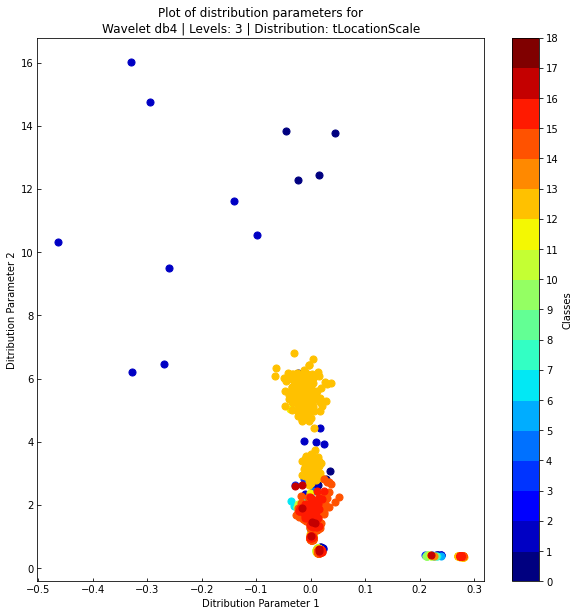

In [10]:
#single Class Plot
dist_params_folder_path = "E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images\\"    
save_folder_path = "E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\Class plots\\"
dist_params_name = "dist_paramsSelect wt=db4 levels=3 dist=tLocationScale.mat"
dist_params_path = os.path.join(dist_params_folder_path, dist_params_name)

class_plot_from_distribution_parameters(dist_params_path, save_folder_path)

# Class populations and data description

In [11]:
#load the data

data , class_titles, ordered_image_names, results= get_data_from_folder("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\")
print("RESULTS\n",results,"\n==========================")
print("CLASS,titles\n",class_titles,"\n===========================")

cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_1_bak.tif' Cichorium Intybus (Asteraceae)_1_bak.tif
cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_3_bak.tif' Cichorium Intybus (Asteraceae)_3_bak.tif
cannot identify image file 'E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Data\\cichorium intubus pollen x 400\\Cichorium Intybus (Asteraceae)_bak.tif' Cichorium Intybus (Asteraceae)_bak.tif
RESULTS
 (367, 3) 
CLASS,titles
 ['castanea 2_pio synithismeni morfi', 'castanea sp', 'Castanea sp. new 22-7-21', 'cichorium intubus pollen x 400', 'citrus sp', 'eukalyptus sp', 'hedera helix', 'helianthus', 'heliotropium', 'hibiscous', 'inula spinoza', 'origanum', 'pinus', 'reiki_calluna vulgaris_020421', 'sonchus', 'thymus capitatus_020421', 'thymus sp pollen 20-0

In [12]:
#class populations
class_list = list( ( enumerate( class_titles ) ) )

dist_paramsSelect_folder_path = "E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images v2 (3 classes of 100)\\"    
dist_paramsSelect_name = "dist_paramsSelect wt=db4 levels=3 dist=Normal.mat"
dist_paramsSelect_path=os.path.join(dist_paramsSelect_folder_path, dist_paramsSelect_name)
df = prepare_features_for_scikit(dist_paramsSelect_path)

class_population=df['Labels'].value_counts(sort=True)

class_dict = dict(class_list)
df4 = pd.DataFrame(class_population)

df4 = df4.reset_index()
df4 = df4.rename(columns={"index":"ClassID", "Labels":"NumberofInstances"})
# class_dict[df4["Class ID"]]

df4["ClassName"] = [class_dict.get(key) for key in df4["ClassID"]]
#df4.to_csv("data description.csv",index=False)
df4

,ClassID,NumberofInstances,ClassName
0,2,109,Castanea sp. new 22-7-21
1,15,101,thymus capitatus_020421
2,13,101,reiki_calluna vulgaris_020421
3,16,26,thymus sp pollen 20-01-21
4,10,8,inula spinoza
5,1,5,castanea sp
6,0,2,castanea 2_pio synithismeni morfi
7,7,2,helianthus
8,11,2,origanum
9,12,1,pinus


# Choosing and Balancing Classes

Although SMVs aren't too sensitive to class population imbalances we balance the population by randomly selecting a number of images from the most populated classes to keep as many as the least populated class.

In [13]:
#keeps the n most populated classes
def get_larger_classes(dist_paramsSelect_folder, dist_paramsSelect_name, n):
    #ready dataframe
    dist_paramsSelect_folder_path = dist_paramsSelect_folder
    dist_paramsSelect_path=os.path.join(dist_paramsSelect_folder_path, dist_paramsSelect_name)

    df = prepare_features_for_scikit(dist_paramsSelect_path)
    class_population=df['Labels'].value_counts(sort=True)

    #keeping n most populated classes
    class_population=df['Labels'].value_counts(sort=True)
    n_most_populated_classes= pd.DataFrame()
    
    for i in range(n):
        n_most_populated_classes = n_most_populated_classes.append(df[df["Labels"]==class_population.index[i]])
        
    return n_most_populated_classes, df

#randomly chooses images of the larger class to balance out dataset
def balance_classes(n_most_populated_classes):
  class_population = n_most_populated_classes['Labels'].value_counts(sort=True)
  smallest_class_population = class_population.iloc[class_population.shape[0]-1]
    
  balanced_classes = pd.DataFrame()
    
  for i in range(class_population.shape[0]):
      to_append = n_most_populated_classes[n_most_populated_classes["Labels"]==class_population.index[i]].sample(smallest_class_population)
      balanced_classes = balanced_classes.append(to_append, ignore_index=True)

  return balanced_classes

# Balancing classes and cross validating SVM

In [14]:
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#cross-validate n most populated classes

number_of_classes = 3
levels = 3
dist = "Normal"
cv_split = 20
wavelet = "db4"

larger_classes, df = get_larger_classes("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images v2 (3 classes of 100)\\" ,\
                                        "dist_paramsSelect wt=db4 levels=3 dist=Normal.mat",\
                                        3)

A=balance_classes(larger_classes).to_numpy()
x=A[:,:-1]
y=A[:,-1]

model=pipeline.Pipeline((\
                         ("scaler",StandardScaler() ),\
                         ("svm_clf", svm.SVC(kernel='rbf', gamma=0.01, C=1, decision_function_shape='ovo'))\
                        ))

scores = cross_val_score(model, x, y, cv=cv_split)
result = pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]})

print("CV results")
result

CV results


,Mean Accuracy,Standard Deviation
0,0.954375,0.057847


# Repeating many times to validate results

In [15]:
#cross-validate n most populated classes
def balance_and_cv(n_most_populated_classes, cv_split):
    A=balance_classes(n_most_populated_classes).to_numpy()
    x=A[:,:-1]
    y=A[:,-1]

    model=pipeline.Pipeline((\
                             ("scaler",StandardScaler() ),\
                             ("svm_clf", svm.SVC(kernel='rbf', gamma=0.01, C=1, decision_function_shape='ovo'))\
                            ))

    scores = cross_val_score(model, x, y, cv=cv_split, n_jobs=-1)
    return scores

In [16]:
#3 balanced classes wt=db4 levels=3 dist=Normal
results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])
larger_classes, df = get_larger_classes("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images v2 (3 classes of 100)\\" ,\
                                        "dist_paramsSelect wt=db4 levels=3 dist=Normal.mat",\
                                        3)
for i in range(100):
    scores=balance_and_cv(larger_classes, cv_split=6)
    results = results.append(pd.DataFrame({"Mean Accuracy":[scores.mean()], "Standard Deviation":[scores.std()]}), ignore_index=True)
    
print(results.describe())
results


       Mean Accuracy  Standard Deviation
count     100.000000          100.000000
mean        0.954261            0.030260
std         0.005382            0.009557
min         0.943595            0.009342
25%         0.950458            0.023754
50%         0.953889            0.029724
75%         0.957141            0.037057
max         0.970131            0.056007


,Mean Accuracy,Standard Deviation
0,0.953725,0.027491
1,0.947059,0.037784
2,0.957255,0.041509
3,0.960458,0.019546
4,0.943856,0.036876
...,...,...
95,0.960261,0.046246
96,0.950523,0.018745
97,0.953856,0.018351
98,0.953725,0.018862


# Histogram of the mean accuracy values produced by reapeating the cross validation step many times

In [21]:
#Helper Function
def train(path_to_distParamsSelect_folder, title_of_mat_file , options, bins=15):

    
    larger_classes, df = get_larger_classes(path_to_distParamsSelect_folder, \
                                            title_of_mat_file, \
                                            options["Number of Classes"])

    instances_per_class = df['Labels'].value_counts(sort=True).iloc[options["Number of Classes"]-1]

    options["Instances per class"] = instances_per_class
    
    results=pd.DataFrame(columns=["Mean Accuracy", "Standard Deviation"])

    for i in range(options["Number of runs"]):
        scores=balance_and_cv(larger_classes, options["CV split"])
        results = results.append(pd.DataFrame({"Mean Accuracy of CV":[scores.mean()], "Standard Deviation of CV":[scores.std()]}), ignore_index=True)

    options["Mean Accuracy"] = results.describe()["Mean Accuracy of CV"].iloc[1]
    options["Standard Deviation of Mean Accuracy"] = results.describe()["Standard Deviation of CV"].iloc[1]
    all_results = pd.DataFrame(columns=["Number of Classes", "Instances per class", "Distribution", "Wavelet", "Levels", "Number of runs", "CV split" ,"Mean Accuracy", "Standard Deviation of Mean Accuracy"])
    all_results = all_results.append(options, ignore_index=True)
    
    #saving hist
    
#    ax = results["Mean Accuracy of CV"].hist( bins=bins )
#    fig = ax.get_figure()
#    ax.set_title("Mean Accuracy of CV")
#    figtitle=""
#    for key in options:
#        figtitle+=key+" "+str(options[key])+" "
#    fig.savefig(figtitle+'.jpg')
    
    return all_results



In [18]:
#To keep all results
all_results = pd.DataFrame(columns=["Number of Classes", "Instances per class", "Distribution", "Wavelet", "Levels", "Number of runs", "CV split" ,"Mean Accuracy", "Standard Deviation of Mean Accuracy"])

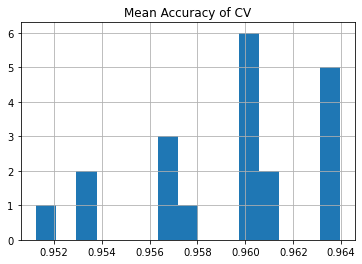

In [84]:
#4 most populated classes wt=db4 levels=3 Normal
number_of_classes = 3
levels = 3
dist = "Normal"
number_of_runs = 20
cv_split = 20
wavelet = "db4"

options = {"Number of Classes":number_of_classes,\
           "Levels":levels,\
           "Distribution":dist,\
           "Number of runs":number_of_runs,\
           "CV split":cv_split,\
           "Wavelet":wavelet}

all_results = all_results.append( train("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images v2 (3 classes of 100)\\" ,\
                                        "dist_paramsSelect wt=db4 levels=3 dist="+options["Distribution"]+".mat",\
                                        options),\
                                  ignore_index=True)

# Evaluating stability as the number of classes increases

In [19]:
all_results = pd.DataFrame(columns=["Number of Classes", "Instances per class", "Distribution", "Wavelet", "Levels", "Number of runs", "CV split" ,"Mean Accuracy", "Standard Deviation of Mean Accuracy"])


In [20]:
options_list = [[2,3,"Normal",2000,20,"db4"],
                [2,3,"tLocationScale",2000,20,"db4"],
                [2,3,"Stable",2000,20,"db4"],
                
                [3,3,"Normal",2000,20,"db4"],
                [3,3,"tLocationScale",2000,20,"db4"],
                [3,3,"Stable",2000,20,"db4"],
                
                [4,3,"Normal",2000,4,"db4"],
                [4,3,"tLocationScale",2000,4,"db4"],
                [4,3,"Stable",2000,4,"db4"],
                
                [5,3,"Normal",2000,2,"db4"],
                [5,3,"tLocationScale",2000,2,"db4"],
                [5,3,"Stable",2000,2,"db4"],
                
                [6,3,"Normal",2000,2,"db4"],
                [6,3,"tLocationScale",2000,2,"db4"],
                [6,3,"Stable",2000,2,"db4"],
                
               ]

In [27]:

for a in options_list:
    options = {"Number of Classes":a[0],\
               "Levels":a[1],\
               "Distribution":a[2],\
               "Number of runs":a[3],\
               "CV split":a[4],\
               "Wavelet":a[5]}
    
    all_results = all_results.append( train("E:\\Backups\\Work&Uni\\University\\ML for food authentication\\Results_fitting\\dist_paramsSelect\\New Images v2 (3 classes of 100)\\" ,\
                                        "dist_paramsSelect wt=db4 levels=3 dist="+options["Distribution"]+".mat",\
                                        options),\
                                  ignore_index=True)
    

In [28]:
all_results.to_csv("increasing classes.csv")

In [31]:
print(all_results.to_latex(float_format="%.2f", columns=("Number of Classes","Instances per class","Distribution","CV split","Mean Accuracy","Standard Deviation of Mean Accuracy")))

\begin{tabular}{lllllrr}
\toprule
{} & Number of Classes & Instances per class &    Distribution & CV split &  Mean Accuracy &  Standard Deviation of Mean Accuracy \\
\midrule
0  &                 2 &                 101 &          Normal &       20 &           1.00 &                                 0.02 \\
1  &                 2 &                 101 &  tLocationScale &       20 &           1.00 &                                 0.02 \\
2  &                 2 &                 101 &          Stable &       20 &           0.99 &                                 0.02 \\
3  &                 3 &                 101 &          Normal &       20 &           0.96 &                                 0.05 \\
4  &                 3 &                 101 &  tLocationScale &       20 &           0.99 &                                 0.03 \\
5  &                 3 &                 101 &          Stable &       20 &           0.99 &                                 0.02 \\
6  &                 4 &  

In [ ]:
all_results

# Plot of accuracy vs the number of classes

In [ ]:
all_results["Distribution"=="Normal"].plot(x="Number of Classes", y="Mean Accuracy")
